<center><font size="+4">Programming & Data Analytics & AI 2 PM 2024/2025</font></center>
<center><font size="+2">Sant'Anna School of Advanced Studies, Pisa, Italy</font></center>
<center><img src="https://github.com/EMbeDS-education/ComputingDataAnalysisModeling20242025/raw/main/PDAI/jupyter/jupyterNotebooks/images/sssaLEMBEDSdtu.png" width="900" alt="L'EMbeDS"></center>

<center><font size="+2">Course responsible</font></center>
<center><font size="+2">Andrea Vandin a.vandin@santannapisa.it</font></center>

---

<center><font size="+2">Notebook for Class 8 </font></center>
<center><font size="+2"> Conformance Checking. Data lab
</font></center>

---
---

In [2]:
url_github_repo="https://github.com/EMbeDS-education/ComputingDataAnalysisModeling20242025/raw/main/PDAI/"

pm_slides=url_github_repo+'jupyter/jupyterNotebooks/images/PM/'
from IPython.display import Image, display

In [5]:
#Here we create a 'string' variable pointing to our repository...
url1 = 'https://raw.githubusercontent.com/EMbeDS-education/ComputingDataAnalysisModeling20242025/main/PDAI/jupyter/jupyterNotebooks/PurchasingExample.csv'
url2 = 'https://raw.githubusercontent.com/EMbeDS-education/ComputingDataAnalysisModeling20242025/main/PDAI/jupyter/jupyterNotebooks/burgers.csv'
url3 = 'https://raw.githubusercontent.com/EMbeDS-education/ComputingDataAnalysisModeling20242025/main/PDAI/jupyter/jupyterNotebooks/simplifiedCustomerComplaintHandling.csv'
url4 = 'https://raw.githubusercontent.com/EMbeDS-education/ComputingDataAnalysisModeling20242025/main/PDAI/jupyter/jupyterNotebooks/simplifiedCustomerComplaintHandling-removed_reinit.csv'
url5 = 'https://raw.githubusercontent.com/EMbeDS-education/ComputingDataAnalysisModeling20242025/main/PDAI/jupyter/jupyterNotebooks/simplifiedCustomerComplaintHandling-doubled_reinit.csv'
url6 = 'https://raw.githubusercontent.com/EMbeDS-education/ComputingDataAnalysisModeling20242025/main/PDAI/jupyter/jupyterNotebooks/simplifiedCustomerComplaintHandling.xes'

urls=[url1,url2,url3,url4,url5,url6]

import urllib.request
from pathlib import Path

for url in urls:
    print('Downloading',url)
    urllib.request.urlretrieve(url,Path(url).name)

For an informed discussion on this topic, I recommend you watching classes of Module 3 of the [Coursera course on PM](https://www.coursera.org/learn/process-mining/home/welcome)
- https://www.coursera.org/learn/process-mining/home/module/3



> Below we provide screenshots from some slides used above

# Overview

Often, one wants to compare an event log with
- A reference (or normative) model
- A mined model

This is done to
- understand whether the expected behavior actually occurs
- identify and analyze deviations
  - These _outliers_ are often the  _interesting cases_
    - some may be good (doctors deviate to save the life of a specific patient)
    - some may be bad (an office forgets performing a quality  check before sending money out)
- compare the quality of different process discovery algorithms

During the classes on pm4py we studied two approaches to conformance checking
- token-based 
  - tells us how much each trace and all logs conform to a model (it counts missing and remaining tokens)
- alignment-based
  1. tells us how much each trace and all logs conform to a model
  2. tells us how to modify the model or traces to make the model conformant


We know that the quality of a model (or of a model discovery technique) can be measured using 4 dimensions
- However, in conformance checking, __replay fitness__ is the most important
  - How well can my model replicate the logs? 

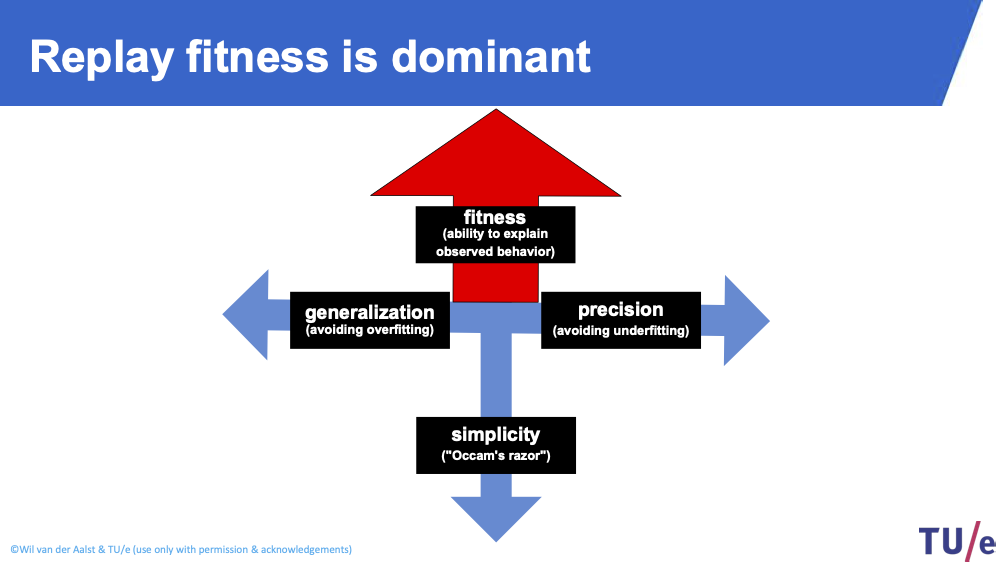

In [4]:
img=Image(pm_slides+'confFitness.png',width=700)
display(img)

Recap on precision and fitness:
- Precision: Ability to produce only traces appearing in the event log
  - Maybe not all traces in the log are covered, but the model shall not create spurious traces
- Fitness: Ability to replay the observed behavior
  - It shall cover all traces in the event log, we don't care about additional spurious traces

When doing conformance checking we can
- Give a global conformance measure
- Give diagnostics information on problems in the __log__ and on how to fix it
- Give diagnostics information on problems in the __model__ and on how to fix it

Not all conformance checking techniques provide these information

# Conformance checking based on Causal footprints

By now, you should know very well the notion of 
- Footprint of an event log

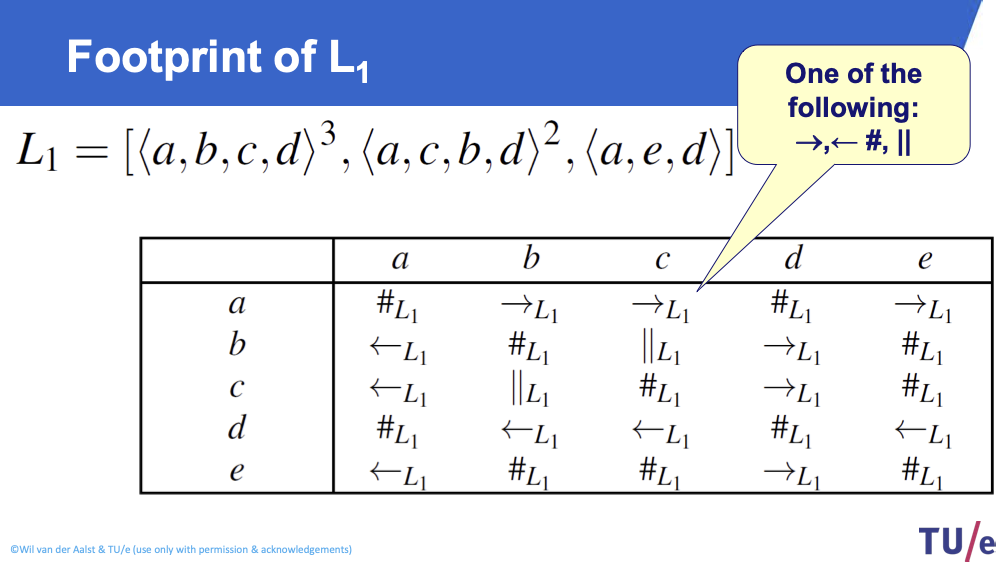

In [6]:
display(Image(pm_slides+'footprint.png',width=700))

The Alpha miner is based on this:
- __Direct succession `>`__
  - `a>b`: There is at least one trace where `b` is the next event after `a`
- __Sequence `->`__ (also __Causality__)
  - `a->b`: `a>b` __and not__ `b>a`
- __Parallel `||`__
  - `a||b`: `a>b` __and__ `b>a`
- __Choice `#`__
  - `a#b`: __not__ `a>b` __and not__ `b>a`

E.g.,
- `a -> b` means that `a` is followed by `b` at least once. While `b` is never followed by `a`
- `c || b` means that `c` is followed by `b` at least once, and vice versa
- `a # d` means that `a` is never  by `d`, and vice versa

You may recall that the __alpha miner guarantees__ that:
- the footprint of the source log
- the footprint of all logs generable by a model

__have the same footprint__

That is, the alpha miner is perfect in finding and modeling these _local dependencies_

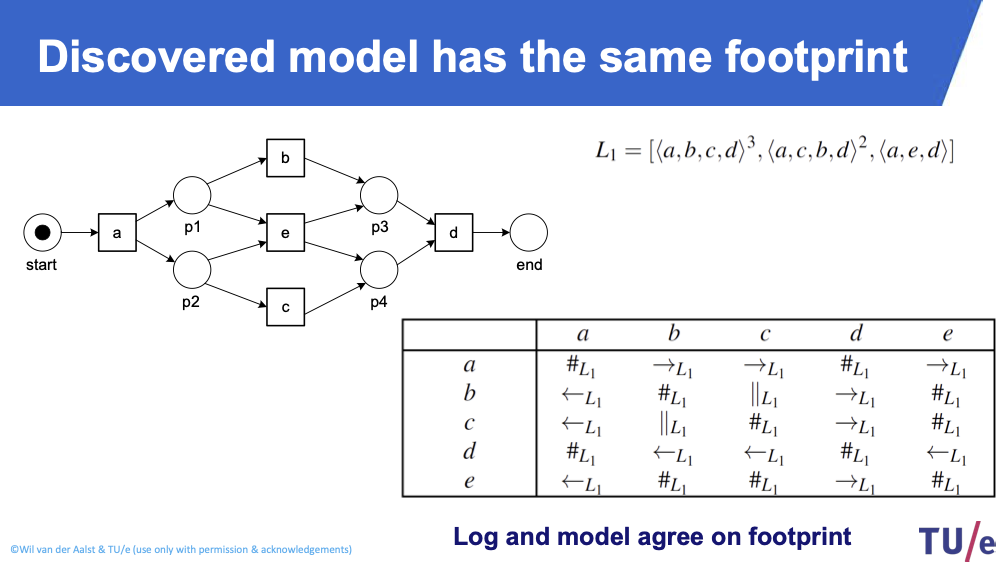

In [8]:
display(Image(pm_slides+'sameFootprint.png',width=700))

Conformance checking based on Causal footprints
- just compares the footrpint of a log and of a model
- we compute the fraction of cells coinciding:
  - 1: perfect match
  - 0: worst match possible  

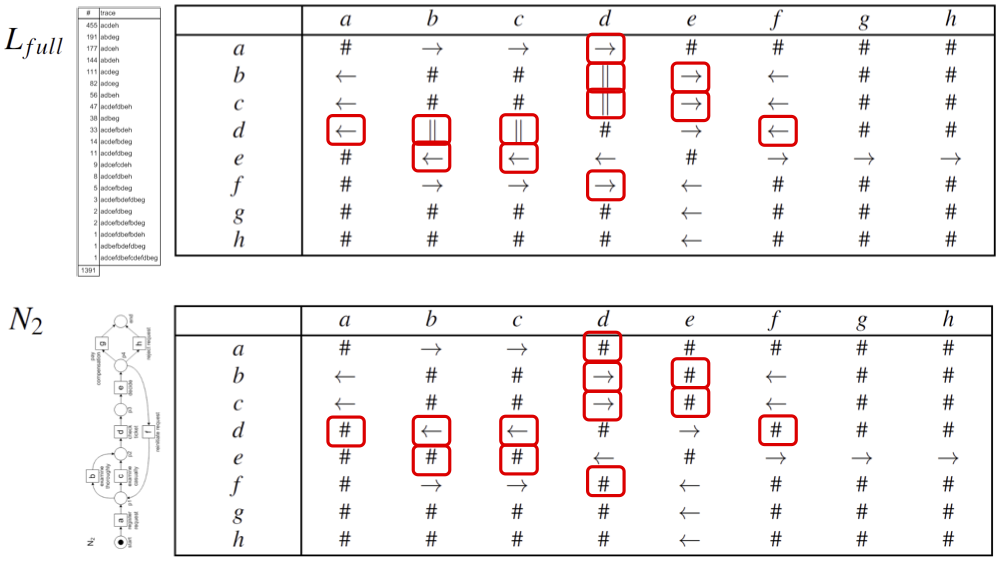

In [9]:
display(Image(pm_slides+'footprintCC.png',width=700))

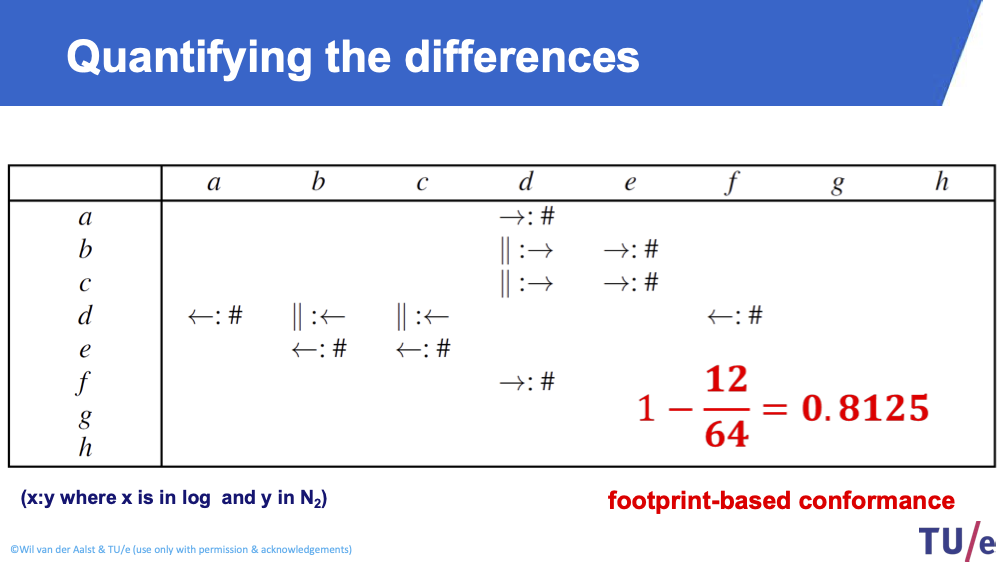

In [11]:
display(Image(pm_slides+'footprintCC2.png',width=700))

The footprint-based conformance checking
- quantifies the differences

However, the picture above also gives __diagnostics__!

Pros:
- Flexible
  - Given that footprints can be generated from models and logs, we can compare model-model, model-log, log-log
- Implicitly capture precision and fitness, indirectly

Cons:
- Frequencies ignored
- Behavior considered indirectly (many processes may have the same footprint...)
- Cannot be used to compute precision and fitness separately. Only mixed together

# Conformance checking based on Token-based replay 

We have discussed token-based conformance checking in the pm4py classes

- intuitively: if there are problems in replaying a trace on a model, 
  - we add tokens trying to 'fill' missing activities (and count how many tokens we added)
  - we count remaining tokens after having reached the final state
  - If both counters are zero, then the logs perfectly match the model
    - they can be replayed
  - Otherwise, there are problems, and the counters give us some info on the number  of problems.
    - Based on this, each trace gets a __fitness__ measure
      - 1: the trace can be replayed 
      - \[0,1): the trace cannot be replayed exactly. The lower the value, the more problematic is the trace (the higher will be the counters)
    - Based on fitness of single traces, we can compute the fitness of a log

This is much more refined than the footprint-based approach
- we reason on the behavior

## Let's load a log and discover a model

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

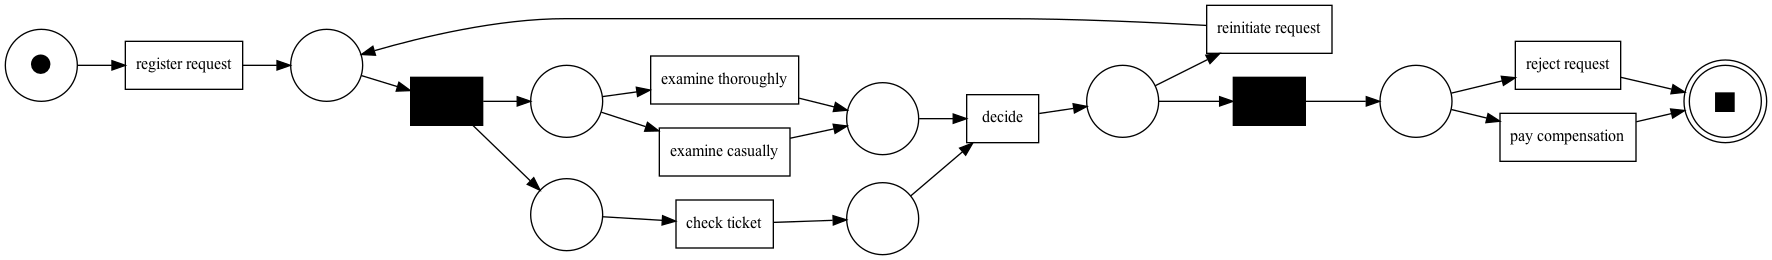

In [16]:
import pm4py
import pandas as pd

#Let's create once more a model: a Petri net
event_log = pm4py.read_xes("simplifiedCustomerComplaintHandling.xes")
pn, im, fm = pm4py.discover_petri_net_inductive(event_log)
places_list=list(pn.places)


pm4py.view_petri_net(pn, im, fm)

## We consider two modified csv files
- simplifiedCustomerComplaintHandling-removed_reinit.csv: we remove the reinitiate event from case 3
- simplifiedCustomerComplaintHandling-doubled_reinit.csv: we double the reinitiate event from case 3

In [17]:
#We now load a CSV file where we removed the rinitiate request from case id 3.
# This log does not comply with the model
event_log_removed_reinit=pd.read_csv("simplifiedCustomerComplaintHandling-removed_reinit.csv",sep=";")
event_log_removed_reinit['timestamp']=pd.to_datetime(event_log_removed_reinit['timestamp'])
event_log_removed_reinit = pm4py.format_dataframe(event_log_removed_reinit, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
print("Original:",len(event_log),"Modified:",len(event_log_removed_reinit))

event_log_removed_reinit[event_log_removed_reinit['case:concept:name']=='3']

Original: 42 Modified: 41


,case_id,activity,timestamp,costs,resource,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
10,3,register request,2010-12-30 13:32:00+00:00,50,Pete,3,register request,2010-12-30 13:32:00+00:00,10,2
11,3,examine casually,2010-12-30 14:06:00+00:00,400,Mike,3,examine casually,2010-12-30 14:06:00+00:00,11,2
12,3,check ticket,2010-12-30 15:34:00+00:00,100,Ellen,3,check ticket,2010-12-30 15:34:00+00:00,12,2
13,3,decide,2011-01-06 08:18:00+00:00,200,Sara,3,decide,2011-01-06 08:18:00+00:00,13,2
14,3,examine thoroughly,2011-01-06 12:06:00+00:00,400,Sean,3,examine thoroughly,2011-01-06 12:06:00+00:00,14,2
15,3,check ticket,2011-01-08 10:43:00+00:00,100,Pete,3,check ticket,2011-01-08 10:43:00+00:00,15,2
16,3,decide,2011-01-09 08:55:00+00:00,200,Sara,3,decide,2011-01-09 08:55:00+00:00,16,2
17,3,pay compensation,2011-01-15 09:45:00+00:00,200,Ellen,3,pay compensation,2011-01-15 09:45:00+00:00,17,2


In [18]:
#We now load a CSV file where we removed the rinitiate request from case id 3.
# This log does not comply with the model
event_log_doubled_reinit=pd.read_csv("simplifiedCustomerComplaintHandling-doubled_reinit.csv",sep=";")
event_log_doubled_reinit['timestamp']=pd.to_datetime(event_log_doubled_reinit['timestamp'])
event_log_doubled_reinit = pm4py.format_dataframe(event_log_doubled_reinit, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
print("Original:",len(event_log),"Modified:",len(event_log_doubled_reinit))

event_log_doubled_reinit[event_log_doubled_reinit['case:concept:name']=='3']

Original: 42 Modified: 43


,case_id,activity,timestamp,costs,resource,case:concept:name,concept:name,time:timestamp,@@index,@@case_index
10,3,register request,2010-12-30 13:32:00+00:00,50,Pete,3,register request,2010-12-30 13:32:00+00:00,10,2
11,3,examine casually,2010-12-30 14:06:00+00:00,400,Mike,3,examine casually,2010-12-30 14:06:00+00:00,11,2
12,3,check ticket,2010-12-30 15:34:00+00:00,100,Ellen,3,check ticket,2010-12-30 15:34:00+00:00,12,2
13,3,decide,2011-01-06 08:18:00+00:00,200,Sara,3,decide,2011-01-06 08:18:00+00:00,13,2
14,3,reinitiate request,2011-01-06 11:18:00+00:00,200,Sara,3,reinitiate request,2011-01-06 11:18:00+00:00,14,2
15,3,reinitiate request,2011-01-06 11:28:00+00:00,200,Sara,3,reinitiate request,2011-01-06 11:28:00+00:00,15,2
16,3,examine thoroughly,2011-01-06 12:06:00+00:00,400,Sean,3,examine thoroughly,2011-01-06 12:06:00+00:00,16,2
17,3,check ticket,2011-01-08 10:43:00+00:00,100,Pete,3,check ticket,2011-01-08 10:43:00+00:00,17,2
18,3,decide,2011-01-09 08:55:00+00:00,200,Sara,3,decide,2011-01-09 08:55:00+00:00,18,2
19,3,pay compensation,2011-01-15 09:45:00+00:00,200,Ellen,3,pay compensation,2011-01-15 09:45:00+00:00,19,2


In [19]:
pm4py.fitness_token_based_replay(event_log,pn,im,fm)

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

{'perc_fit_traces': 100.0,
 'average_trace_fitness': 1.0,
 'log_fitness': 1.0,
 'percentage_of_fitting_traces': 100.0}

We can see that:
 - `'perc_fit_traces': and 100.0` : all traces perfectly match
 -  `'average_trace_fitness': 1.0` : the average of the fitness of each trace is 1
 - `'log_fitness': 1.0` : not important for now. Think of it as '
 - `'percentage_of_fitting_traces'`: 100.0 : same as `'perc_fit_traces'`

In [20]:
pm4py.fitness_token_based_replay(event_log_removed_reinit,pn,im,fm)

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

{'perc_fit_traces': 83.33333333333333,
 'average_trace_fitness': 0.9802350427350427,
 'log_fitness': 0.9784679089026915,
 'percentage_of_fitting_traces': 83.33333333333333}

In [21]:
pm4py.fitness_token_based_replay(event_log_doubled_reinit,pn,im,fm)

replaying log with TBR, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

{'perc_fit_traces': 83.33333333333333,
 'average_trace_fitness': 0.9895833333333334,
 'log_fitness': 0.9863013698630136,
 'percentage_of_fitting_traces': 83.33333333333333}

## Let us show some animations using a selection of slides from Prof Wil van der Aalst

Taken and adapted from 
- https://www.coursera.org/lecture/process-mining/4-5-conformance-checking-using-token-based-replay-tCz6j

In [28]:
from IPython.display import IFrame
IFrame(pm_slides+'Conformance-Checking-Using-Token-Based-Replay.pdf', width=200, height=200)

# Conformance checking based on Alignment

## Overview

Alignment-based conformance checking is the most advanced one among the considered ones

We have discussed in detail alignment-based conformance checking in the pm4py classes

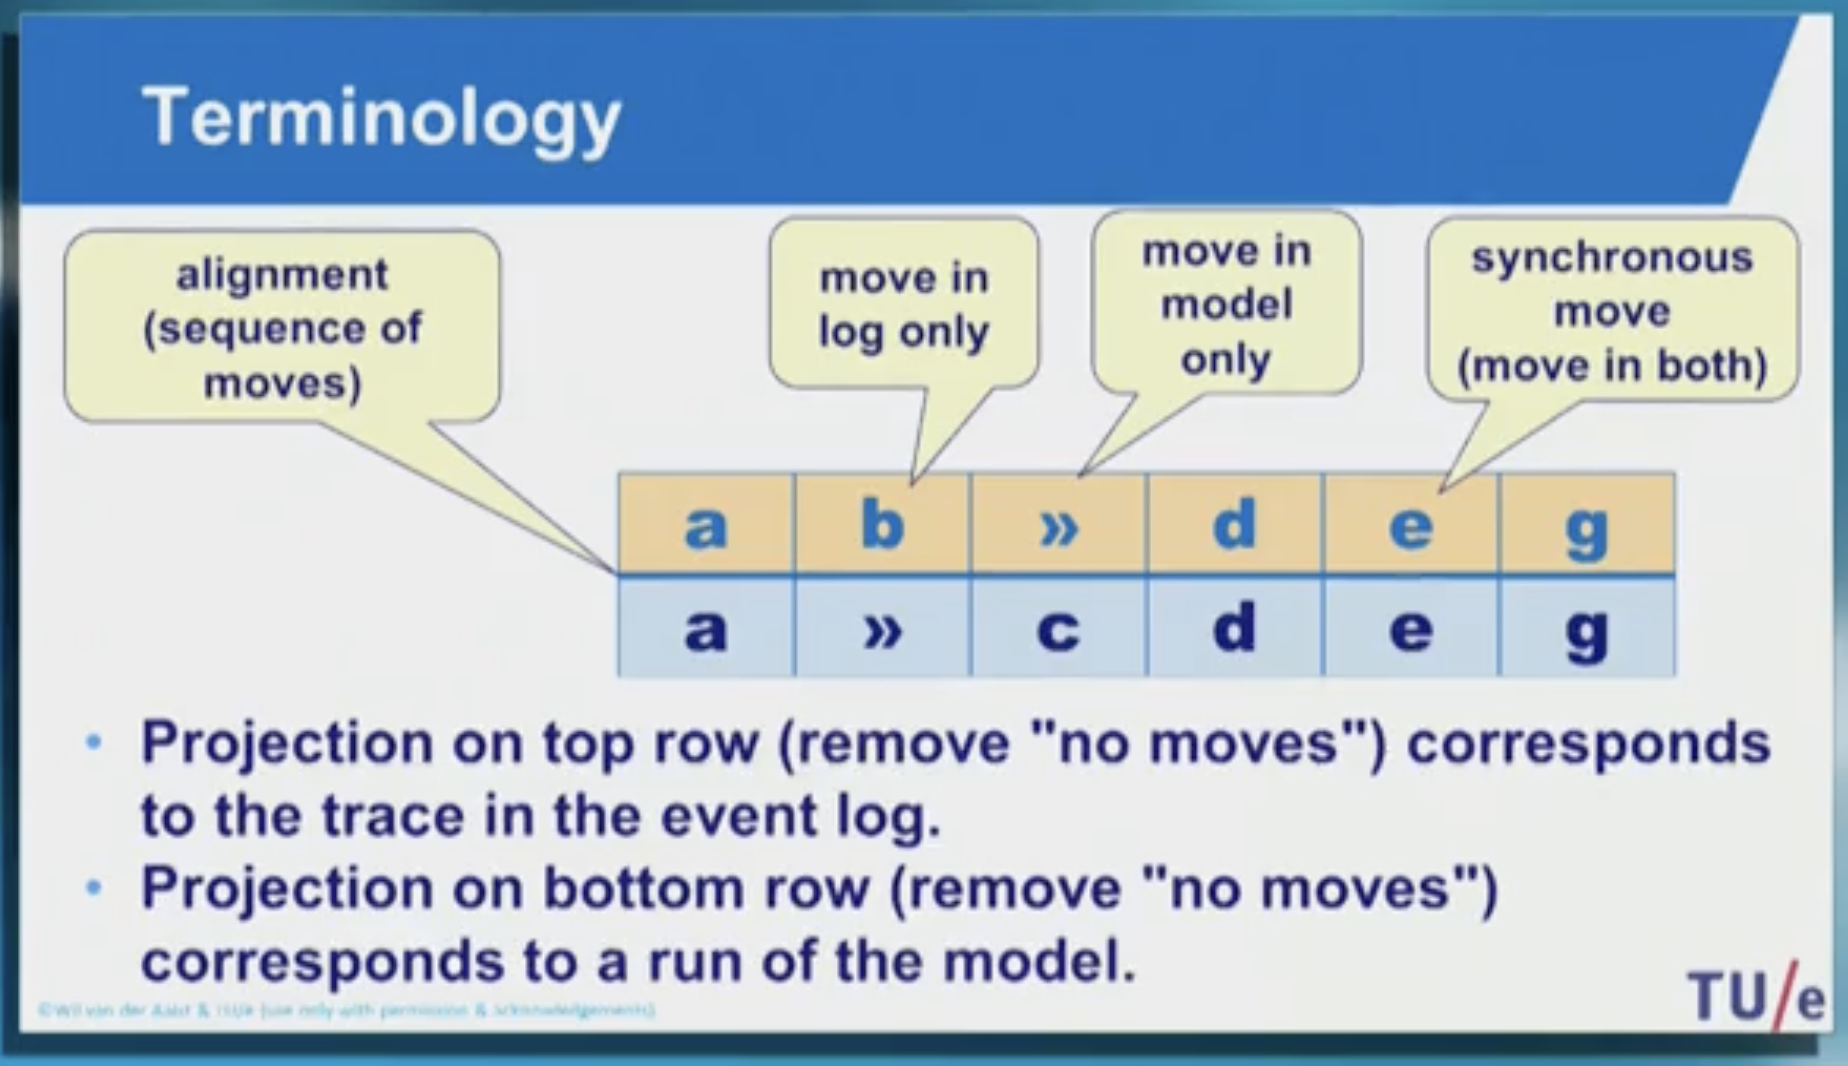

In [31]:
display(Image(pm_slides+'alignment.png',width=700))

## In pm4py

In [32]:
pm4py.fitness_alignments(event_log,pn,im,fm)

aligning log, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

{'percFitTraces': 100.0,
 'averageFitness': 1.0,
 'percentage_of_fitting_traces': 100.0,
 'average_trace_fitness': 1.0,
 'log_fitness': 0.9999791670138831}

In [33]:
pm4py.fitness_alignments(event_log_removed_reinit,pn,im,fm)

aligning log, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

{'percFitTraces': 83.33333333333333,
 'averageFitness': 0.9871794871794872,
 'percentage_of_fitting_traces': 83.33333333333333,
 'average_trace_fitness': 0.9871794871794872,
 'log_fitness': 0.9858946045982322}

Now we can get diagnostics.

Diagnostics are given in terms of __moves__:
- `(activity_1,activity_1)` means _log and model move_, or _synchronous move_: I have an activity that can be performed by both the log and the model. It is __OK__
- `(activity_1,>>)` means: _log move_: an activity that the model cannot replicate
- `(>>,activity_1)` means: _model move_: an activity that the log cannot replicate

Imagine we have this trace:
- `<register request, register request, examine casually, check ticket, reject request>`

An alignment is:
  - `(register request, register request)`
  - `(register request, >>)`   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    HERE WE NEED TO ALIGN!
  - `(examine casually, examine casually)`
  - `(check ticket, check ticket)`
  - `(>>, decide)`  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    HERE WE NEED TO ALIGN!
  - `(reject request,reject request)`
  
  
<br/><br/>
Please note: `(>>, None)` is OK
- None represents a silent transition. It is _implictly matched_ by `>>`.

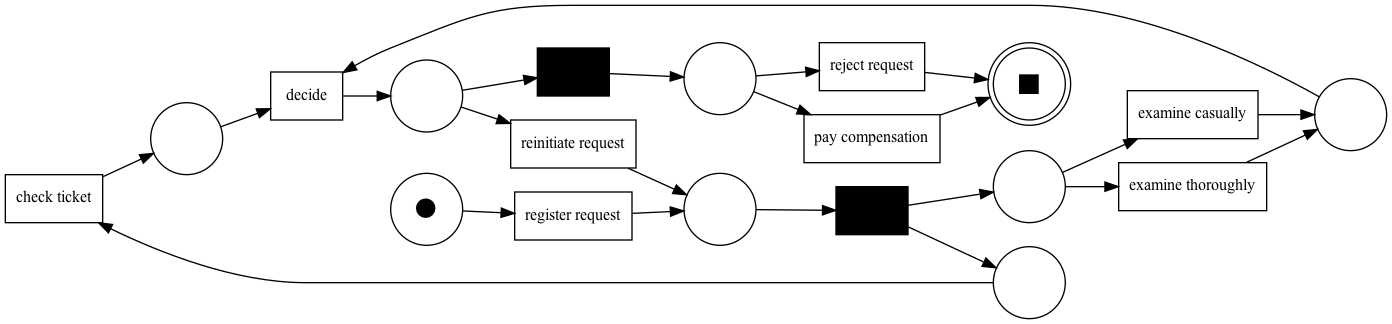

In [34]:
pm4py.view_petri_net(pn, im, fm)

If you read the 'right' column in the alignment above, ignore `>>`, 
- You get the model behavior that fits best the trace!
- The notion of _best_ can be tuned by providing specific cost functions

In [35]:
#event_log_removed_reinit
diagnostics= pm4py.conformance_diagnostics_alignments(event_log_removed_reinit,pn,im,fm)
diagnostics

aligning log, completed variants ::   0%|          | 0/6 [00:00<?, ?it/s]

[{'alignment': [('register request', 'register request'),
   ('>>', None),
   ('examine thoroughly', 'examine thoroughly'),
   ('check ticket', 'check ticket'),
   ('decide', 'decide'),
   ('>>', None),
   ('reject request', 'reject request')],
  'cost': 2,
  'visited_states': 7,
  'queued_states': 23,
  'traversed_arcs': 23,
  'lp_solved': 1,
  'fitness': 1.0,
  'bwc': 100002},
 {'alignment': [('register request', 'register request'),
   ('>>', None),
   ('check ticket', 'check ticket'),
   ('examine casually', 'examine casually'),
   ('decide', 'decide'),
   ('>>', None),
   ('pay compensation', 'pay compensation')],
  'cost': 2,
  'visited_states': 7,
  'queued_states': 24,
  'traversed_arcs': 24,
  'lp_solved': 1,
  'fitness': 1.0,
  'bwc': 100002},
 {'alignment': [('register request', 'register request'),
   ('>>', None),
   ('examine casually', 'examine casually'),
   ('check ticket', 'check ticket'),
   ('decide', 'decide'),
   ('>>', 'reinitiate request'),
   ('>>', None),
   (

In [36]:
print('No problem in the first trace')
diagnostics[0]['alignment']

No problem in the first trace


[('register request', 'register request'),
 ('>>', None),
 ('examine thoroughly', 'examine thoroughly'),
 ('check ticket', 'check ticket'),
 ('decide', 'decide'),
 ('>>', None),
 ('reject request', 'reject request')]

In [37]:
print('No problem in the second trace')
diagnostics[1]['alignment']

No problem in the second trace


[('register request', 'register request'),
 ('>>', None),
 ('check ticket', 'check ticket'),
 ('examine casually', 'examine casually'),
 ('decide', 'decide'),
 ('>>', None),
 ('pay compensation', 'pay compensation')]

In [38]:
diagnostics[1]

{'alignment': [('register request', 'register request'),
  ('>>', None),
  ('check ticket', 'check ticket'),
  ('examine casually', 'examine casually'),
  ('decide', 'decide'),
  ('>>', None),
  ('pay compensation', 'pay compensation')],
 'cost': 2,
 'visited_states': 7,
 'queued_states': 24,
 'traversed_arcs': 24,
 'lp_solved': 1,
 'fitness': 1.0,
 'bwc': 100002}

In [39]:
print('PROBLEM in the third trace!')
diagnostics[2]['alignment']

PROBLEM in the third trace!


[('register request', 'register request'),
 ('>>', None),
 ('examine casually', 'examine casually'),
 ('check ticket', 'check ticket'),
 ('decide', 'decide'),
 ('>>', 'reinitiate request'),
 ('>>', None),
 ('examine thoroughly', 'examine thoroughly'),
 ('check ticket', 'check ticket'),
 ('decide', 'decide'),
 ('>>', None),
 ('pay compensation', 'pay compensation')]

In [ ]:
diagnostics[2]

## Optimal alignment

Traces can be aligned in multiple ways
- Sometimes it is trivial to get the _best alignment_

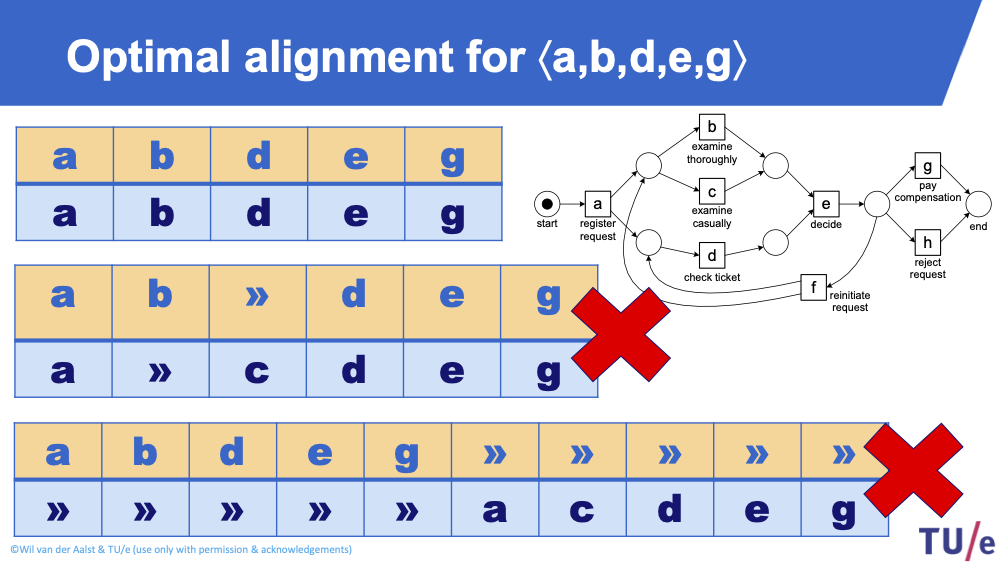

In [33]:
display(Image(pm_slides+'optAlignment.png',width=700))

Other times it is not easy
- Actually, it depends on several factors
- Certain errors/alignments are more costly than others
  - We introduce a notion of _cost function_
  - The optimal alignment is the one with lowest cost